In [18]:
from model_2 import *
from data_2 import *
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [19]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  2


In [20]:
N_training = 40
N_validate = 10
batch_size = 4

train_ids = np.arange(N_training)
print(train_ids)
train_generator = DataGenerator(train_ids, '../training_data_v1/', '../training_data_v1/', do_fft = False, batch_size = batch_size)

validation_ids = np.arange(N_training, N_training+N_validate)
print(validation_ids)
validation_generator = DataGenerator(validation_ids, '../training_data_v1/', '../training_data_v1/', do_fft = False, batch_size = batch_size)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]
Initialized with 1000 total IDs
[40 41 42 43 44 45 46 47 48 49]
Initialized with 250 total IDs


In [21]:
with tf.device('/GPU:1'):
    model = unet()
    print(model.summary())

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 2) 0                                            
__________________________________________________________________________________________________
conv2d_46 (Conv2D)              (None, 256, 256, 64) 1216        input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_47 (Conv2D)              (None, 256, 256, 64) 36928       conv2d_46[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_8 (MaxPooling2D)  (None, 128, 128, 64) 0           conv2d_47[0][0]                  
____________________________________________________________________________________________

In [22]:
with tf.device('/GPU:1'):
    model.fit_generator(train_generator, validation_data=validation_generator, epochs=30)

Epoch 1/30
250/250 [==============================] - 42s 168ms/step - loss: 0.0025 - mean_squared_error: 0.0049 - val_loss: 0.0015 - val_mean_squared_error: 0.0031
Epoch 2/30
250/250 [==============================] - 42s 170ms/step - loss: 0.0011 - mean_squared_error: 0.0023 - val_loss: 0.0015 - val_mean_squared_error: 0.0030
Epoch 3/30
250/250 [==============================] - 43s 171ms/step - loss: 0.0011 - mean_squared_error: 0.0021 - val_loss: 0.0011 - val_mean_squared_error: 0.0023
Epoch 4/30
250/250 [==============================] - 43s 171ms/step - loss: 0.0010 - mean_squared_error: 0.0020 - val_loss: 0.0013 - val_mean_squared_error: 0.0026
Epoch 5/30
250/250 [==============================] - 43s 173ms/step - loss: 8.9340e-04 - mean_squared_error: 0.0018 - val_loss: 0.0010 - val_mean_squared_error: 0.0020
Epoch 6/30
250/250 [==============================] - 43s 174ms/step - loss: 8.5609e-04 - mean_squared_error: 0.0017 - val_loss: 7.7395e-04 - val_mean_squared_error: 0.001

In [23]:
# Load test data
cardiac_test = np.load('../tagsim/test_data_v1.npz')

truth_data = cardiac_test['truth']

test_data = cardiac_test['test']

X = np.zeros(test_data.shape + (2,))
X[:,:,:,0] = np.real(test_data)
X[:,:,:,1] = np.imag(test_data)

with tf.device('/GPU:1'):
    res = model.predict(X)

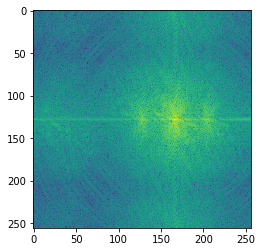

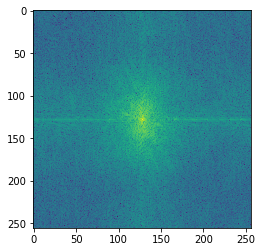

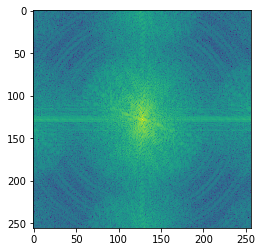

In [24]:
plt.figure()
plt.imshow(np.log(np.abs(np.fft.fftshift(np.fft.fft2(np.fft.fftshift(im_X))))))

plt.figure()
plt.imshow(np.log(np.abs(np.fft.fftshift(np.fft.fft2(np.fft.fftshift(im_res[11]))))))

plt.figure()
plt.imshow(np.log(np.abs(np.fft.fftshift(np.fft.fft2(np.fft.fftshift(im_truth[11]))))))

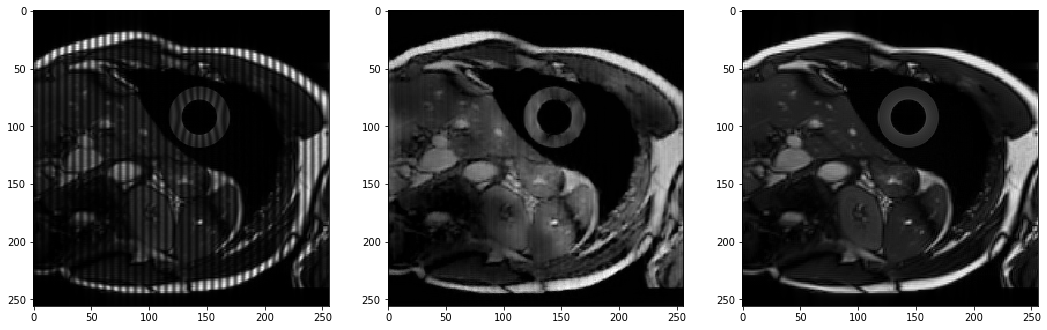

In [25]:
#Visualize magnitude of input, results, truth

tt = 11

im_X = X[tt,:,:,0] + 1j * X[tt,:,:,1]
im_res = res[tt,:,:,0] + 1j * res[tt,:,:,1]
im_truth = truth_data[tt]

fig, axs = plt.subplots(1, 3, squeeze=False, figsize=(18,8))

axs[0,0].imshow((np.abs(im_X)), cmap='gray')
axs[0,1].imshow((np.abs(im_res)), cmap='gray')
axs[0,2].imshow((np.abs(im_truth)), cmap='gray')

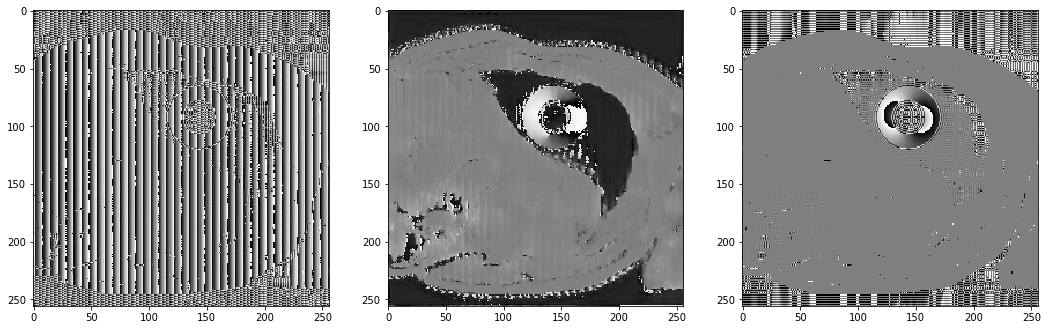

In [26]:
#Visualize phase of input, results, truth

tt = 11

im_X = X[tt,:,:,0] + 1j * X[tt,:,:,1]
im_res = res[tt,:,:,0] + 1j * res[tt,:,:,1]
im_truth = truth_data[tt]

fig, axs = plt.subplots(1, 3, squeeze=False, figsize=(18,8))

axs[0,0].imshow((np.angle(im_X)), cmap='gray')
axs[0,1].imshow((np.angle(im_res)), cmap='gray')
axs[0,2].imshow((np.angle(im_truth)), cmap='gray')

Total Error: 0.48843879 mm  +/- 0.56564826 mm


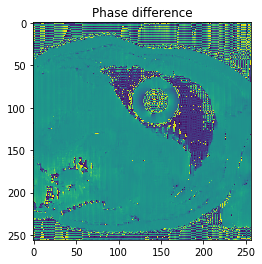

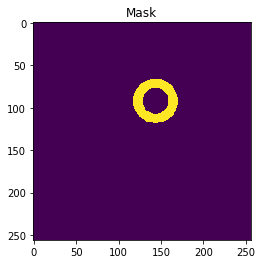

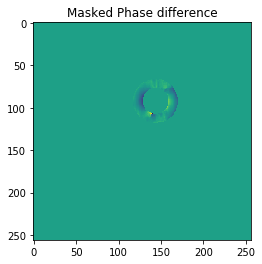

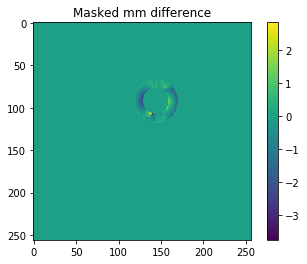

In [27]:
# Compute error:

# Phase difference of results and truth
im_res = res[:,:,:,0] + 1j * res[:,:,:,1]
im_truth = truth_data
ph_diff = np.angle(im_res * np.exp(-1j * np.angle(im_truth)))


# Plot phase difference
tt_show = 11  # timeframe to look at
plt.figure()
plt.imshow(ph_diff[tt_show])
plt.title('Phase difference')

# We dont actually care about anything but the hard, I saved a mask in the test dataset
mask = cardiac_test['mask']
plt.figure()
plt.imshow(mask[tt_show])
plt.title('Mask')

# Multiply results by the mask
ph_diff_mask = ph_diff * mask
plt.figure()
plt.imshow(ph_diff_mask[tt_show])
plt.title('Masked Phase difference')

# Convert to mm error
ke = 0.12 # This was set in simulation
mm_diff_mask = ph_diff_mask / (2*np.pi) / ke
plt.figure()
plt.imshow(mm_diff_mask[tt_show])
plt.colorbar()
plt.title('Masked mm difference')

# Calculate mean and standard deviation error, time frame specific
# We mask differently because we don't want to incorporate all the zeros from masking
err_mean = []
err_std = []
for tt in range(im_res.shape[0]):
    t_diff = mm_diff_mask[tt, mask[tt]>0]
    err_mean.append(t_diff.mean())
    err_std.append(t_diff.std())

# print('Time resolved mean error:', err_mean)
# print('Time resolved stdev error:', err_std)

# And the total error as a single metric
total_err = mm_diff_mask[mask>0]
print('Total Error:', np.abs(total_err).mean(), 'mm  +/-', np.abs(total_err).std(), 'mm')

## Tuning ideas
* Use all timeframes together
  * As channels (3D convolutions will be too expensive)
* Operate in k-space
* Which loss function is best
* Operate in image space, but loss function in k-space
* Play with activation functions, where to use batch normalization, learning rate adjustments, batch size
* Check initial image normalization (zero mean, stdev = 1)

## Implement validation, test data
* Validate on different simulations
* Test on the cardiac simulation
* Eventually we will test on our acquired DENSE data (I need to prep it)

In [28]:
list(cardiac_test.keys())

['test', 'truth', 'mask']

In [29]:
X.shape

(25, 256, 256, 2)

In [30]:
X.shape

(25, 256, 256, 2)